## Parallel processing 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import solaris.preproc.pipesegment as pipesegment
import solaris.preproc.image as image
import solaris.preproc.sar as sar
import solaris.preproc.optical as optical
import solaris.preproc.label as label

/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
plt.rcParams['figure.figsize'] = [4, 4]
datadir = r'//home//jupyter//solaris//solaris//data//preproc_tutorial'

Defining the pansharpening class

In [3]:
class Pansharpening(pipesegment.PipeSegment):
    def __init__(self, ms_path, pan_path, output_path):
        super().__init__()
        load_ms = image.LoadImage(ms_path) \
            * image.ShowImage(bands=[2,1,0], vmin=0, vmax=250, width=12, caption= 'Low-res color imagery')
        resize_ms = image.Resize(600, 600)
        color_ms = optical.RGBToHSV(rband=2, gband=1, bband=0)
        load_pan = image.LoadImage(pan_path) \
            * image.ShowImage(bands=[0], vmin=0, vmax=250, width=12, caption= 'High-res panchromatic image')
        stack1 = image.MergeToStack()
        get_hs = image.SelectBands((0, 1))
        get_v = sar.BandMath(lambda x: x[3] * np.mean(x[2]) / np.mean(x[3]))
        stack2 = image.MergeToStack()
        color_output = optical.HSVToRGB(hband=0, sband=1, vband=2) \
            * image.ShowImage(vmin=0, vmax=250, width=12, caption= 'High-res color imagery (pan-sharpened)')
        save_output = image.SaveImage(output_path)
        self.feeder = (load_ms * resize_ms * color_ms + load_pan) * stack1 \
            * (get_hs + get_v) * stack2 * color_output# * save_output


[('//home//jupyter//solaris//solaris//data//preproc_tutorial/ms1.tif', '//home//jupyter//solaris//solaris//data//preproc_tutorial/pan1.tif', '//home//jupyter//solaris//solaris//data//preproc_tutorial/output2a.tif'), ('//home//jupyter//solaris//solaris//data//preproc_tutorial/ms2.tif', '//home//jupyter//solaris//solaris//data//preproc_tutorial/pan2.tif', '//home//jupyter//solaris//solaris//data//preproc_tutorial/output2b.tif'), ('//home//jupyter//solaris//solaris//data//preproc_tutorial/ms3.tif', '//home//jupyter//solaris//solaris//data//preproc_tutorial/pan3.tif', '//home//jupyter//solaris//solaris//data//preproc_tutorial/output2c.tif')]
Low-res color imagery
Low-res color imageryLow-res color imagery



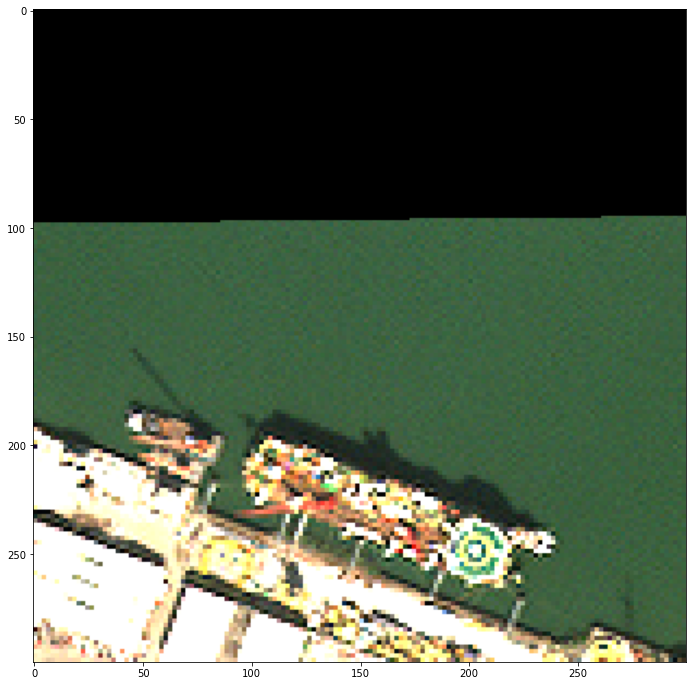

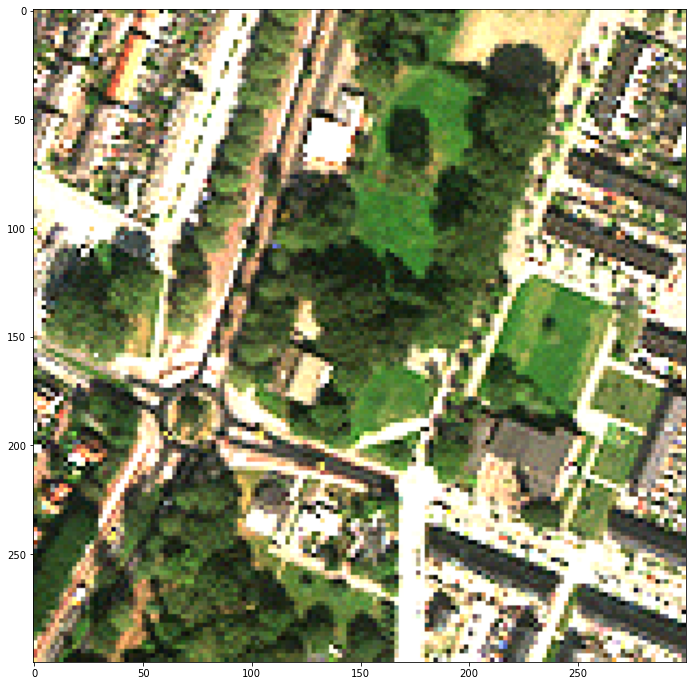

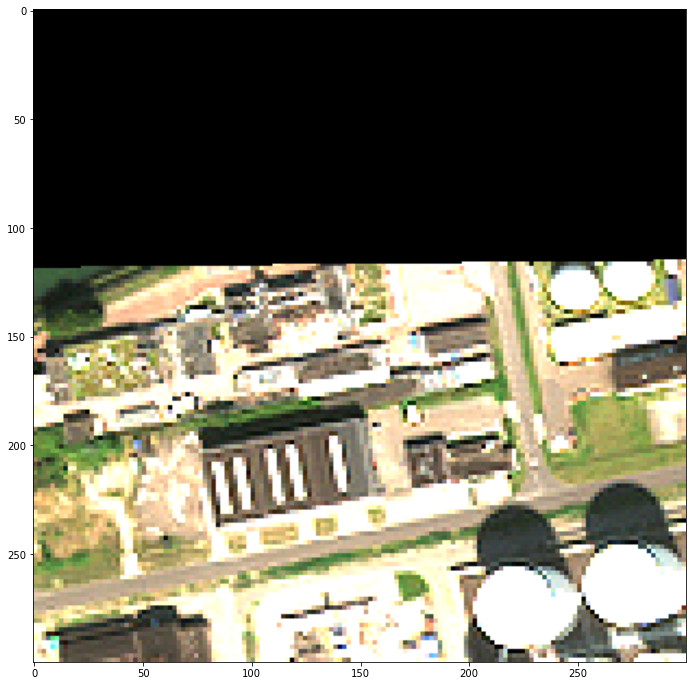

High-res panchromatic image
High-res panchromatic image
High-res panchromatic image


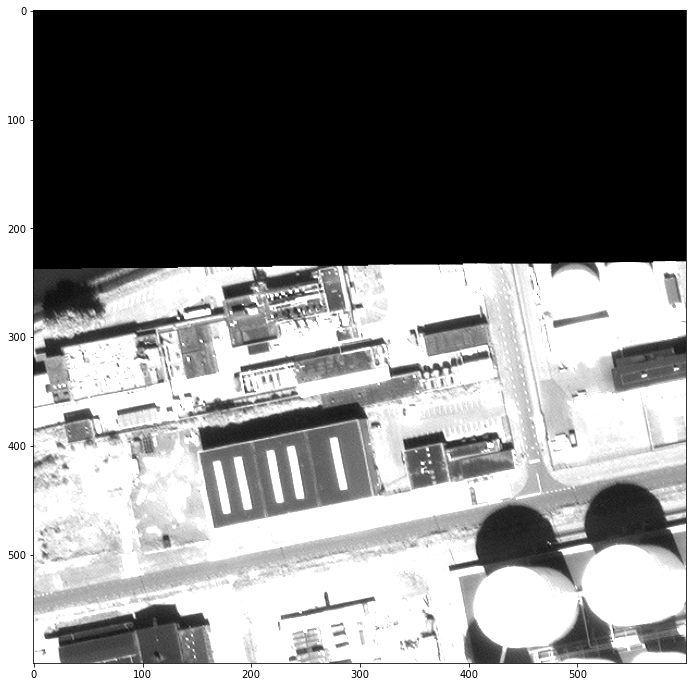

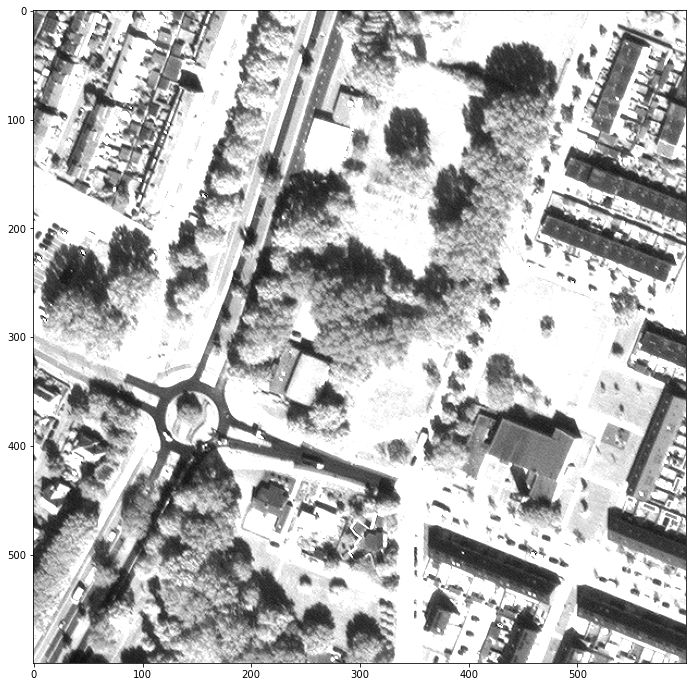

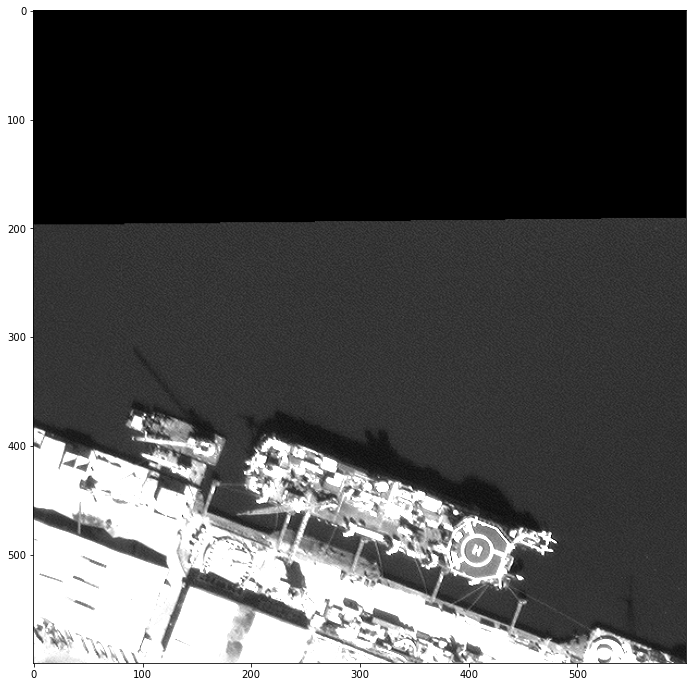

High-res color imagery (pan-sharpened)
High-res color imagery (pan-sharpened)
High-res color imagery (pan-sharpened)


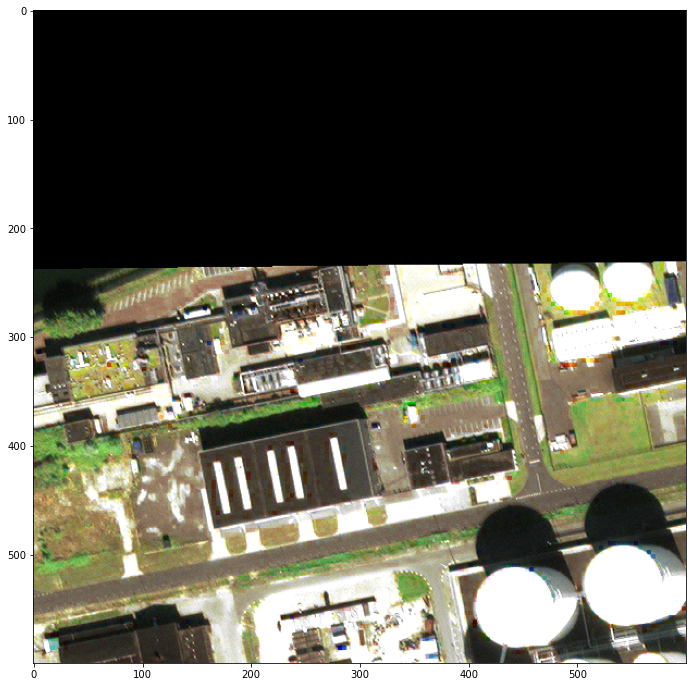

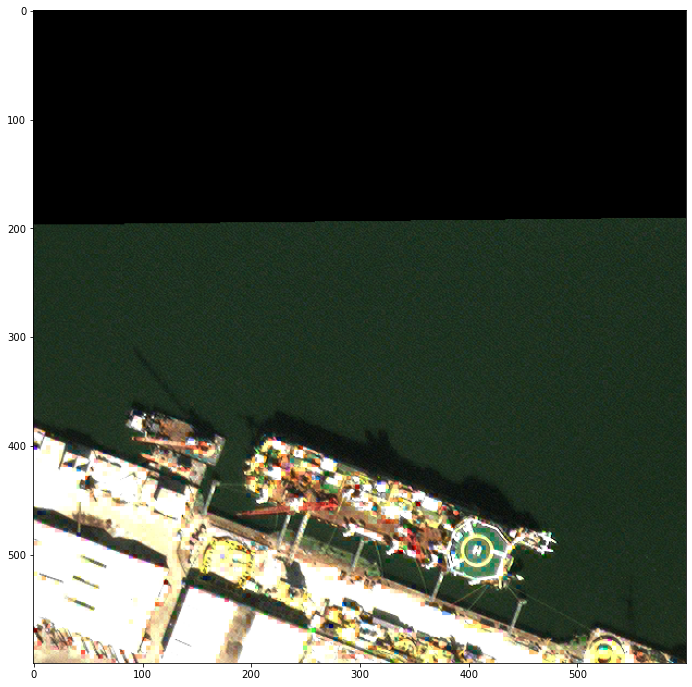

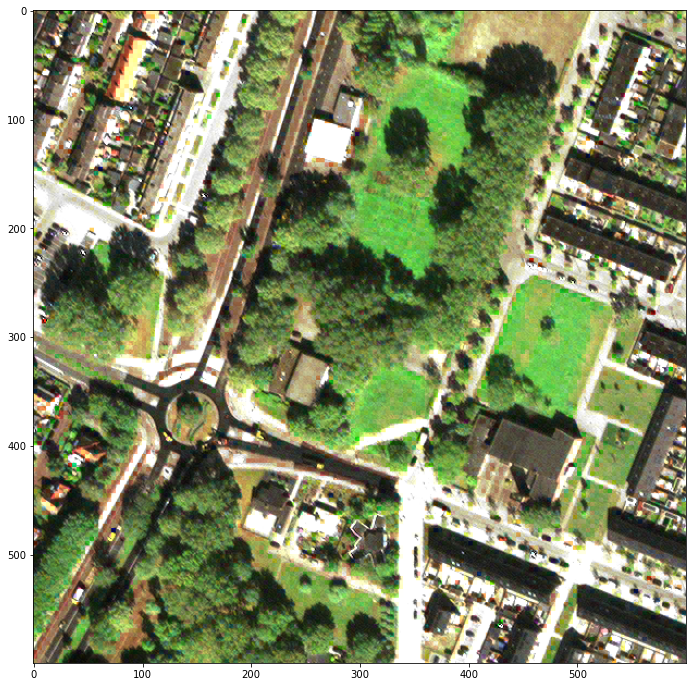

In [4]:
#Specify all the file paths
ms_paths = [os.path.join(datadir, file) for file in ['ms1.tif', 'ms2.tif', 'ms3.tif']]
pan_paths = [os.path.join(datadir, file) for file in ['pan1.tif', 'pan2.tif', 'pan3.tif']]
output_paths = [os.path.join(datadir, file) for file in ['output2a.tif', 'output2b.tif', 'output2c.tif']]
input_args = list(zip(ms_paths, pan_paths, output_paths))
print(input_args)

#Run the jobs in parallel
Pansharpening.parallel(input_args)

## Processing with SAR Imagery 

Intensity


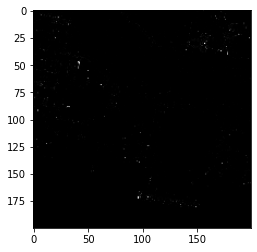

Multilook (Boxcar Filter)


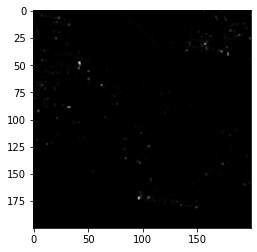

Conversion to Decibels


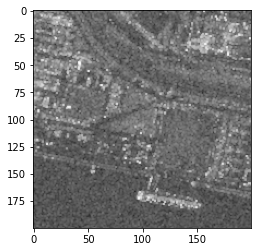

Orthorectification


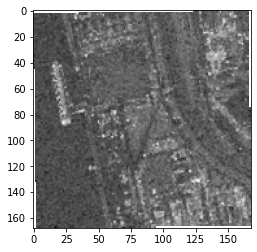

In [5]:
class SARClass(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        self.feeder = (
            image.LoadImage(os.path.join(datadir, 'sar_hh.tif'))
            * sar.CapellaScaleFactor()
            * sar.Intensity() * image.ShowImage(caption='Intensity')
            * sar.Multilook(2) * image.ShowImage(caption='Multilook (Boxcar Filter)')
            * sar.Decibels() * image.ShowImage(caption='Conversion to Decibels')
            * sar.Orthorectify(projection = 32631, row_res=3, col_res=3) * image.ShowImage(caption='Orthorectification')
            #* image.SaveImage(os.path.join(datadir, 'output3a.tif'))
        )

sar_processing = SARClass()
sar_processing()

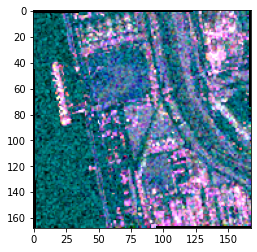

In [8]:
class SARDecomposition(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        loadlist = [image.LoadImage(os.path.join(datadir, file))
                    * sar.CapellaScaleFactor() for file in
                    ['sar_hh.tif', 'sar_hv.tif', 'sar_vh.tif', 'sar_vv.tif']]
        stack = np.sum(loadlist) * image.MergeToStack()
        self.feeder = (
            stack
            * sar.DecompositionPauli(hh_band=0, vv_band=3, xx_band=1)
            * sar.Multilook(2)
            * sar.Decibels()
            * sar.Orthorectify(projection = 32631, row_res=3, col_res=3)
            #* image.SaveImage(os.path.join(datadir, 'output3b.tif'))
            * image.ShowImage(bands=[1,2,0], vmin=-20, vmax=0)
        )

sar_decomposition = SARDecomposition()
sar_decomposition()

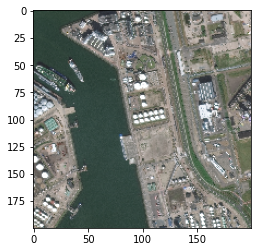

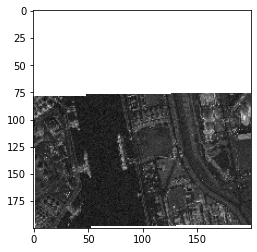

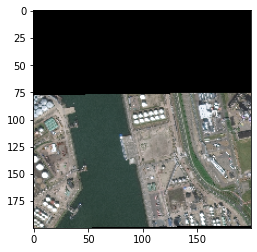

In [7]:
class TransferMask(pipesegment.PipeSegment):
    def __init__(self, masked_path, unmasked_path, output_path):
        super().__init__()
        load_masked = image.LoadImage(masked_path) * image.ShowImage(bands=[0])
        load_unmasked = image.LoadImage(unmasked_path) * image.ShowImage()
        get_mask = image.GetMask()
        set_mask = image.SetMask(0)
        show_output = image.ShowImage() #* image.SaveImage(output_path) 
        self.feeder = (load_unmasked + load_masked * get_mask) * set_mask * show_output

masked_path = os.path.join(datadir, 'sar_masked.tif')
unmasked_path = os.path.join(datadir, 'rgb_unmasked.tif')
output_path = os.path.join(datadir, 'output3c.tif')
transfer_mask = TransferMask(masked_path, unmasked_path, output_path)
transfer_mask()